<a href="https://colab.research.google.com/github/Venkatpolavarapu/Data-Science/blob/master/RNN_Model_Pytorch_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

torch.manual_seed(1)

In [3]:
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
torch.Size([60000, 28, 28])
torch.Size([60000])




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


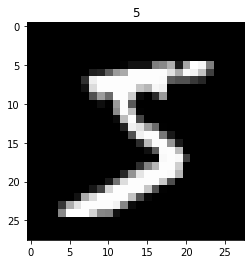

In [4]:
# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [5]:
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.
# shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [7]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [8]:

rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [9]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [12]:
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.2607 | test accuracy: 0.10
Epoch:  0 | train loss: 1.0302 | test accuracy: 0.54
Epoch:  0 | train loss: 0.7169 | test accuracy: 0.72
Epoch:  0 | train loss: 0.4848 | test accuracy: 0.79
Epoch:  0 | train loss: 0.5468 | test accuracy: 0.85
Epoch:  0 | train loss: 0.2137 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2521 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3803 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1658 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1789 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0569 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1033 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2027 | test accuracy: 0.94
Epoch:  0 | train loss: 0.3354 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2017 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2099 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0620 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1109 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2022 | test accuracy

In [11]:

# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 7 7 7 7 7 7 7 7 7] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
